# Учебный Проект → «Золото» ✨

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.  
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.  
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  
Нужно:

- [Подготовить данные](#ready);
- [Провести исследовательский анализ данных](#steady);
- [Построить и обучить модель](#go);

Метрика качества  
Для решения задачи введём новую метрику качества — **sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).  

$$\large
sMAPE = \frac{1}{N} * \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} * 100\%
$$

Нужно спрогнозировать сразу две величины:
  
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`;

$$\large
sMAPE = 25\% * sMAPE_{rougher} + 75\% * sMAPE_{final}
$$

## Описание данных

Данные находятся в трёх файлах:

- `gold_recovery_train_new.csv` — обучающая выборка;
- `gold_recovery_test_new.csv` — тестовая выборка;
- `gold_recovery_full_new.csv` — исходные данные;

### Технологический процесс

`Rougher feed` — исходное сырье  
`Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
- `Xanthate` **— ксантогенат (промотер, или активатор флотации);  
- `Sulphate` — сульфат (на данном производстве сульфид натрия);  
- `Depressant` — депрессант (силикат натрия).  

`Rougher process` (англ. «грубый процесс») — флотация  
`Rougher tails` — отвальные хвосты  
`Float banks` — флотационная установка  
`Cleaner process` — очистка  
`Rougher Au` — черновой концентрат золота  
`Final Au` — финальный концентрат золота  

<hr>

# Загружаем данные

Импортируем библиотеки 🎒

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState


from matplotlib import rcParams

# import networkx as nx

from scipy.stats import t
from scipy.stats import bootstrap

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# from sklearn.feature_selection import mutual_info_regression
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline

Настроим вид графиков по+красоте ✨

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
                # 'font.sans-serif': [
                #     'Helvetica',
                #     'Verdana',
                #     'Tahoma',
                #     'Trebuchet MS',
                #     'Arial',
                #     'Chevin'
                #     ]
                }

# rcParams.update(custom_params)

In [4]:
# set max columns to none
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

Константы.

In [5]:
random_seed = 108108108
random_np = RandomState(128) 
dpi_k = custom_params['figure.dpi'] / rcParams['figure.dpi']
px = 1/custom_params['figure.dpi']

Функции.

In [6]:
def baisic_df_info(data_df, title='Basic Info'):
    print(title, end='\n\n')
    print('Дубликатов:',
             len(data_df.loc[data_df.duplicated()].index),
          end='\n\n'
     )
    
    display(
        data_df.info(),
        data_df.sample(5),
        data_df.describe(),
    )

In [7]:
def to_px(size_px):
    px_density = int(
        round(
            size_px * px * dpi_k
        )
    )
    return px_density

In [8]:
def plot_hist(full_data_col, data, title='Histogram', custom_params=custom_params):
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=1,
            ncols=3,
            figsize=(
                to_px(960), to_px(320)),
            tight_layout=True
        )
        
        n_bins = int(len(data.index) / 100)
        to_descr  = pd.DataFrame()
        
        for n, col_name in enumerate(full_data_col):
            methal = col_name.split('_')[-1]
            to_descr[methal] = data.loc[
                    ~data[col_name].isna(),
                    col_name
                ]
            if methal == 'au':
                hist_color = 'goldenrod'
            else :
                hist_color = 'darkmagenta'
                
            axs[n].hist(
                to_descr[methal],
                bins=n_bins,
                color=hist_color
            )
            axs[n].set_xlim(0, 60)
            axs[n].set_title(methal)
        
        fig.suptitle(title, fontsize=16)

        plt.show()
        
        return to_descr

In [9]:
def plot_hist_conc(data, title='Histogram', custom_params=custom_params):
    rougher_concentrate = [
            'rougher.output.concentrate_ag',
            'rougher.output.concentrate_pb',
            'rougher.output.concentrate_sol',
            'rougher.output.concentrate_au',
    ]
    primary_concentrate = [
            'primary_cleaner.output.concentrate_ag',
            'primary_cleaner.output.concentrate_pb',
            'primary_cleaner.output.concentrate_sol',
            'primary_cleaner.output.concentrate_au',
    ]
    final_concentrate = [
            'final.output.concentrate_ag',
            'final.output.concentrate_pb',
            'final.output.concentrate_sol',
            'final.output.concentrate_au',
    ]
    
    rc = data.loc[: ,
                     rougher_concentrate
                ].dropna(axis=0).apply(sum, axis=1)
    pc = data.loc[: ,
                    primary_concentrate
                ].dropna(axis=0).apply(sum, axis=1)
    fc = data.loc[: ,
                    final_concentrate
                ].dropna(axis=0).apply(sum, axis=1)
    
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=1,
            ncols=3,
            figsize=(
                to_px(960), to_px(320)),
            tight_layout=True
        )
        
        n_bins = int(len(data.index) / 100)
        
        axs[0].hist(
            x=rc,
            bins=n_bins,
            color='forestgreen',
        )
        axs[0].set_xlim(0, 90)
        axs[0].set_title('Rougher')
        
        axs[1].hist(
            x=pc,
            bins=n_bins,
            color='forestgreen',
        )
        axs[1].set_xlim(0, 90)
        axs[1].set_title('Primary')
        
        axs[2].hist(
            x=fc,
            bins=n_bins,
            color='forestgreen',
        )
        axs[2].set_xlim(0, 90)
        axs[2].set_title('Final')
        
        fig.suptitle(title, fontsize=16)

        plt.show()
    
    return (rc, pc, fc)

In [10]:
def plot_feed_size_hist(data_train, data_test, title='Histogram', custom_params=custom_params):
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=1,
            ncols=2,
            figsize=(
                to_px(1024), to_px(512)),
            tight_layout=True
        )
        
        n_bins = 1_000
        n_bins_train = int(len(data_train.index) / 100)
        n_bins_test = int(len(data_test.index) / 100)
     
        axs[0].hist(
            data_train.loc[~data_train.isna()],
            bins=n_bins,
            color='forestgreen'
        )
        axs[0].set_xlim(0, 500)
        axs[0].set_title('Train')
        
        axs[1].hist(
            data_test.loc[~data_test.isna()],
            bins=n_bins,
            color='forestgreen'
        )
        axs[1].set_xlim(0, 500)
        axs[1].set_title('Test')
        
        fig.suptitle(title, fontsize=16)

        plt.show()

<hr>

$$\large
recovery = \frac {C * (F - T) }{F * (C -T)} * 100\%
$$

где:

- C — `rougher.output.concentrate_au` доля золота в концентрате после флотации/очистки;
- F — `rougher.input.feed_au` доля золота в сырье/концентрате до флотации/очистки;
- T — `rougher.output.tail_au` доля золота в отвальных хвостах после флотации/очистки;

In [11]:
def calc_recovery(concentrate_au, feed_au, tail_au):
    c = concentrate_au
    f = feed_au
    t = tail_au
    
    recovery = ((c * (f - t)) / (f * (c - t))) * 100
    
    return recovery

<hr>

<a id='ready'></a>
## 1. Подготовим данные

### 1.1. Загрузим файлы и изучим данные.

> Данные индексируются датой и временем получения информации (признак date)

In [12]:
try:
    gold_recovery_train = pd.read_csv(
        './datasets/gold_recovery_train_new.csv',
        index_col='date',
    )
    gold_recovery_test = pd.read_csv(
        './datasets/gold_recovery_test_new.csv',
        index_col='date',
    )
    gold_recovery_full = pd.read_csv(
        './datasets/gold_recovery_full_new.csv',
        index_col='date',
    )
    
except FileNotFoundError:
    gold_recovery_train = pd.read_csv(
        'https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv',
        index_col='date',
    )
    gold_recovery_test = pd.read_csv(
        'https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv',
        index_col='date',
    )
    gold_recovery_full = pd.read_csv(
        'https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv',
        index_col='date',
    )
    print('FYI datasets loaded via url')

In [13]:
gold_recovery_train.index = pd.to_datetime(gold_recovery_train.index)
gold_recovery_test.index = pd.to_datetime(gold_recovery_test.index)
gold_recovery_full.index = pd.to_datetime(gold_recovery_full.index)

In [14]:
baisic_df_info(gold_recovery_train, 'Обучающая Выборка')

Обучающая Выборка

Дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.o

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-24 02:59:59,5.754616,11.796231,12.977361,42.886241,62.264743,10.703777,4.097371,10.568826,4.275502,163.506455,9.921051,7.45,0.395491,7.783206,11.056167,9.163766,34.002394,16.825188,4.068729,8.078824,7.209488,1753.301134,-499.181558,1758.822917,-498.918191,1752.394848,-501.111172,1752.878947,-504.933399,48039.638496,3463.616317,3463.978613,1.955530,10.241146,4.975494,417.722305,53.919253,40.017818,9.729726,14.999560,5.400789,15.001573,5.399297,13.057557,9.122886,32.041798,21.892791,86.006634,6.204449,0.792259,16.888742,2.203942,1227.007899,-300.132641,1230.796165,-499.064529,1267.295017,-498.874637,1115.887659,-496.620975,994.351465,-497.532940,983.098594,-496.327851,15.596177,5.215010,9.549763,4.830032,34.893207,-499.621979,30.049617,-499.713357,35.998573,-499.485142,33.980389,-499.464819,24.971162,-498.067653,22.992128,-499.737788,25.969906,-499.373165,23.982582,-499.409029,17.972015,-498.445889
2017-08-04 11:59:59,3.917219,12.101429,7.566961,45.667344,62.836974,

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

In [15]:
baisic_df_info(gold_recovery_test, 'Тестовая Выборка')

Тестовая Выборка

Дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-26 00:59:59,232.824185,9.976345,7.37,2.475801,1500.763021,-501.274302,1499.731350,-498.253442,1502.670415,-504.242303,1500.679535,-530.521336,9.980013,5.366334,611.910465,69.345599,41.170440,10.310788,17.243509,8.197975,17.239340,8.204192,1206.502987,-399.914804,1001.627274,-500.073729,1000.663442,-499.976600,799.491108,-499.797114,800.347402,-499.836214,700.051860,-500.169598,24.918663,-499.779646,23.047235,-500.151633,29.977352,-499.953353,19.943292,-500.018843,16.983039,-496.489024,14.874627,-494.028185,10.976062,-499.900955,8.963450,-499.745200,16.008541,-499.533880
2017-10-13 11:59:59,103.297593,5.012732,6.79,1.417539,1398.074172,-500.458138,1399.359294,-499.270419,1398.155634,-499.980848,1401.205886,-499.415939,5.421516,3.297284,299.963012,31.233403,37.387101,7.246034,13.002051,4.513213,13.000815,4.506733,1003.025588,-300.407651,1103.073665,-500.839920,1052.243900,-500.736503,1009.555298,-499.670848,900.236110,-500.809628,899.903579,-501.370172,24.883912,-503.306303,21.995686,-573.523677,22.001092,-500.320629,20.049286,-500.937475,17.963310,-501.568917,15.975386,-399.842922,12.952660,-501.060354,10.012114,-499.891666,13.991433,-501.181185
2017-11-26 15:59:59,211.634970,10.986462,7.45,2.095236,1603.171356,-499.475307,1602.758471,-499.968013,1600.992488,-500.381994,1600.703317,-506.440254,10.032514,4.244016,578.471410,69.039181,40.792909,9.204586,15.509313,8.200253,15.508749,8.199647,1205.870163,-399.885538,1005.084266,-499.029152,1001.947200,-499.065818,808.852158,-498.996304,800.858407,-499.090781,700.745098,-499.202044,24.928945,-500.068854,22.869138,-499.486540,24.951189,-499.824298,20.036071,-499.854639,16.981738,-501.610601,15.029862,-500.271262,10.925815,-498.897797,8.989850,-499.523942,15.994169,-499.725307
2017-11-22 21:59:59,234.236447,9.992986,7.57,2.086461,1647.759340,-499.857874,1648.251093,-499.484773,1649.104070,-500.317693,1651.036729,-499.254696,10.822405,5.325327,586.600517,72.039869,41.537362,11.300512,16.993760,7.860924,16.994185,7.854885,1102.686161,-399.980883,1000.391108,-500.828079,1002.343460,-500

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

In [16]:
baisic_df_info(gold_recovery_full, 'Исходные Данные')

Исходные Данные

Дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.out

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-10 03:59:59,6.635251,8.796182,13.265761,45.946624,79.164708,9.668076,0.798733,14.482087,1.927712,147.028997,8.001814,7.170000,1.203672,11.013433,10.420398,16.809295,33.395146,19.232920,4.516799,9.425145,3.344817,1599.486063,-549.215108,1598.435984,-501.205841,1599.974748,-540.106798,1598.580491,-578.416975,45140.117979,2498.280949,2497.853657,3.108192,10.393700,2.567420,560.434947,84.071850,41.350920,7.980035,8.758002,6.003684,8.756977,6.002604,0.000000,0.000000,0.000000,0.000000,0.000000,4.981813,0.464294,21.151276,0.930996,1397.864546,-300.300045,999.542731,-500.465967,900.275809,-500.873949,802.876610,-500.378981,NaN,-500.637291,849.535055,-501.067795,19.345528,6.470776,3.902114,4.450544,29.928168,-500.620482,26.997854,-503.417249,29.980484,-499.132111,19.982061,-499.847665,20.018215,-498.851020,15.132322,-499.702049,10.961717,-500.995852,9.052033,-499.894413,11.014808,-504.183351
2016-02-04 17:00:00,5.663869,9.844806,NaN,43.657998,55.358461,11.592386,1.500124,

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438

In [17]:
to_plot = (
    # (
    #     'rougher.input.feed_ag',
    #     'rougher.input.feed_pb',
    #     'rougher.input.feed_au',
    # ),
    (
        'rougher.output.concentrate_ag',
        'rougher.output.concentrate_pb',
        'rougher.output.concentrate_au',
    ) ,
    # (
    #     'rougher.output.tail_ag',
    #     'rougher.output.tail_pb',
    #     'rougher.output.tail_au',
    # ),
    (
        'primary_cleaner.output.concentrate_ag',
        'primary_cleaner.output.concentrate_pb',
        'primary_cleaner.output.concentrate_au',
    ),
    # (
    #     'primary_cleaner.output.tail_ag',
    #     'primary_cleaner.output.tail_pb',
    #     'primary_cleaner.output.tail_au',
    # ),
    # (
    #     'secondary_cleaner.output.tail_ag',
    #     'secondary_cleaner.output.tail_pb',
    #     'secondary_cleaner.output.tail_au',
    # ),
    (
        'final.output.concentrate_ag',
        'final.output.concentrate_pb',
        'final.output.concentrate_au',
    ),
    # (
    #     'final.output.tail_ag',
    #     'final.output.tail_pb',
    #     'final.output.tail_au',
    # ),
)

### 1.2. Проверим, что эффективность обогащения рассчитана правильно

In [18]:
print(
    'Строк в тренировочной выборке:',
    len(gold_recovery_train.index)
)

Строк в тренировочной выборке: 14149


In [19]:
display(
    gold_recovery_train['rougher.output.recovery'].notna().sum(),
    gold_recovery_train['rougher.output.concentrate_au'].notna().sum(),
    gold_recovery_train['rougher.input.feed_au'].notna().sum(),
    gold_recovery_train['rougher.output.tail_au'].notna().sum(),
)

14149

14149

14149

14149

Данные для вычислений на месте)

####  Вычислим эффективность обогащения на `train` выборке для признака `rougher.output.recovery`

$$\large
recovery_{train} = \frac {C * (F - T) }{F * (C -T)} * 100\%
$$

где:

- C — `rougher.output.concentrate_au` доля золота в концентрате после флотации;
- F — `rougher.input.feed_au` доля золота в сырье/концентрате до флотации;
- T — `rougher.output.tail_au` доля золота в отвальных хвостах после флотации;

In [20]:
gold_recovery_train['rougher.calculation.recovery'] = gold_recovery_train.loc[:, 
        ['rougher.output.concentrate_au',
        'rougher.input.feed_au',
        'rougher.output.tail_au',]
    ].apply(lambda to_calc:
            calc_recovery(
                to_calc['rougher.output.concentrate_au'],
                to_calc['rougher.input.feed_au'],
                to_calc['rougher.output.tail_au']
            ),
            axis=1
    )

In [21]:
display(
    gold_recovery_train.loc[: ,
        ['rougher.calculation.recovery', 'rougher.output.recovery']
    ].sample(5)
)

,rougher.calculation.recovery,rougher.output.recovery
date,,
2017-07-13 21:59:59,64.477159,64.477159
2018-05-23 13:59:59,80.413264,80.413264
2018-02-27 06:59:59,90.173945,90.173945
2016-02-29 02:00:00,89.079613,89.079613
2018-03-17 14:59:59,92.477615,92.477615


####  Найдём MAE между расчётами и значением признака

$$\large
MAE = \frac{1}{N} * \sum_{i=1}^{N} |y_i - x_i|
$$

In [22]:
print(
    'MAE между расчётами и значением признака rougher.output.recovery',
    mean_absolute_error(
        gold_recovery_train['rougher.output.recovery'],
        gold_recovery_train['rougher.calculation.recovery'],
    ),
    sep=':\n'
)

MAE между расчётами и значением признака rougher.output.recovery:
9.73512347450521e-15


In [23]:
display(
    gold_recovery_train.loc[
        gold_recovery_train['rougher.output.recovery'] != gold_recovery_train['rougher.calculation.recovery'],
        ['rougher.output.recovery', 'rougher.calculation.recovery']
    ].sample(7)
)

,rougher.output.recovery,rougher.calculation.recovery
date,,
2018-01-14 18:59:59,90.440853,90.440853
2016-06-04 05:59:59,67.728334,67.728334
2016-02-04 16:00:00,60.412636,60.412636
2018-06-14 05:59:59,81.273330,81.273330
2017-02-09 06:59:59,87.701371,87.701371
2018-06-26 13:59:59,89.245600,89.245600
2017-04-16 03:59:59,84.038392,84.038392


####  Выводы

MAE, конечно, довольно мало, но вот вопрос как это $MAE \neq 0$ !?  
Похоже, дело в `python` и его бинарной особенности в работе с `float`..🐍

In [24]:
train_rougher_calculation_recovery = gold_recovery_train['rougher.calculation.recovery'] 

gold_recovery_train.drop(
    'rougher.calculation.recovery',
    axis=1,
    inplace=True,
)

### 1.3. Проанализируем признаки, недоступные в тестовой выборке.

> Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.  
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.  

> В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

####  Что это за параметры?

In [25]:
not_in_test = list(
        set(gold_recovery_train.columns)
        - set(gold_recovery_test.columns)
    )

In [26]:
PHASE_ORDER = {
    'rougher': 'a',
    'primary_cleaner': 'b',
    'secondary_cleaner': 'c',
    'final': 'd',
}

TYPE_ORDER = {
    'input': 'a',
    'output': 'b',
    'state': 'c',
    'calculation': 'd',
}

In [27]:
def to_process_order(col_name):
    order = PHASE_ORDER[col_name.split('.')[0]] + TYPE_ORDER[col_name.split('.')[1]] + col_name.split('.')[2]
    return order

In [28]:
train_test_col = pd.DataFrame(
        sorted(
            gold_recovery_train.columns,
            key=lambda col: to_process_order(col)
        ),
        columns=['train']
    )

train_test_col['test'] = train_test_col['train'].apply(
        lambda col: col if col in set(gold_recovery_test.columns) else ''
    )

display(
    train_test_col
)

,train,test
0,rougher.input.feed_ag,rougher.input.feed_ag
1,rougher.input.feed_au,rougher.input.feed_au
2,rougher.input.feed_pb,rougher.input.feed_pb
3,rougher.input.feed_rate,rougher.input.feed_rate
4,rougher.input.feed_size,rougher.input.feed_size
5,rougher.input.feed_sol,rougher.input.feed_sol
6,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_sulfate
7,rougher.input.floatbank10_xanthate,rougher.input.floatbank10_xanthate
8,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_sulfate
9,rougher.input.floatbank11_xanthate,rougher.input.floatbank11_xanthate


#### К какому типу относятся?

В тестовой выборке нет данных с типом параметра:  
`'calculation'`  
`'output'`  
  
С `'calculation'` понятно, что если оставить в `train` эти параметры, то они приведут с собой `Мультиколлинеарность` 👫.  
  
С `'output'` параметрами интереснее, потомучто золотая часть из них учавствует в расчете `recovery`.  
То есть мы их и собираемся предсказывать, точнее предсказывать будем `recovery`. А в формулу `recovery` входят `output.concentrate_au` и `output.tail_au`..

> Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже.  
  
Модель ждать не будет 💃

#### 1.4. Проведите предобработку данных

Добавим в `test` выборку целевые признаки из выборки `full`.

In [29]:
gold_recovery_test.loc[: ,
        ['rougher.output.recovery', 'final.output.recovery',]
    ] = gold_recovery_full.loc[
            gold_recovery_test.index,
            ['rougher.output.recovery', 'final.output.recovery',]
        ]

Уберём из `train` выборки все признаки, которых нет в `test` выборке.

In [30]:
not_in_test = list(
        set(gold_recovery_train.columns)
        - set(gold_recovery_test.columns)
    )

In [31]:
gold_recovery_train.drop(
    labels=not_in_test,
    axis=1,
    inplace=True,
)

> Соседние по времени параметры часто похожи.

Заполним пропуски в данных предыдущими значениями по методу `ffill`:  
> propagate last valid observation forward to next

хотя, медиана между значениями лучше бы подошла, странно что такого метода нет..

In [32]:
gold_recovery_train.sort_index(
    axis=0,
    inplace=True,
)

gold_recovery_train.fillna(
    method='ffill',
    inplace=True,
)

In [33]:
gold_recovery_test.sort_index(
    axis=0,
    inplace=True,
)

gold_recovery_test.fillna(
    method='ffill',
    inplace=True,
)

Отсортируем колонки по этапам обработки.

In [34]:
gold_recovery_train = gold_recovery_train.reindex(
    labels=sorted(
        gold_recovery_train.columns,
        key=lambda col: to_process_order(col),
    ),
    axis=1,
)

In [35]:
gold_recovery_test = gold_recovery_test.reindex(
    labels=sorted(
        gold_recovery_test.columns,
        key=lambda col: to_process_order(col),
    ),
    axis=1,
)

In [36]:
display(
    gold_recovery_train.info(),
    gold_recovery_test.info(),
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_ag                       14149 non-null  float64
 1   rougher.input.feed_au                       14149 non-null  float64
 2   rougher.input.feed_pb                       14149 non-null  float64
 3   rougher.input.feed_rate                     14149 non-null  float64
 4   rougher.input.feed_size                     14149 non-null  float64
 5   rougher.input.feed_sol                      14149 non-null  float64
 6   rougher.input.floatbank10_sulfate           14149 non-null  float64
 7   rougher.input.floatbank10_xanthate          14149 non-null  float64
 8   rougher.input.floatbank11_sulfate           14149 non-null  float64
 9   rougher.input.floatbank11_xanthate          1414

None

None

In [37]:
display(
    list(gold_recovery_train.columns),
)

['rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.recovery',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floa

<hr>

<a id='steady'></a>
## 2. Проанализируйте данные

In [38]:
def descr_methals(metals_df, phase_title, perc=[.005, .025,  .5, .975, .995]):
    print(phase_title)
    display(
        pd.DataFrame(
            data=np.reshape(
                metals_df.describe(percentiles=perc).values,
                [-1, 3]
            ),
            index=metals_df.describe(percentiles=perc).index,
            columns=metals_df.columns
        )
    )

### 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

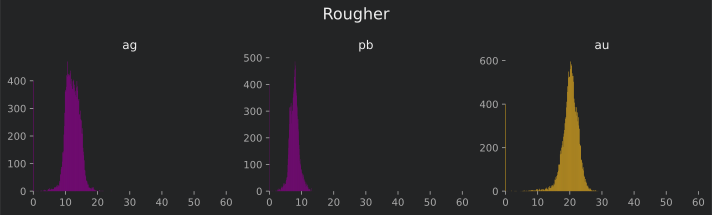

In [39]:
rm = plot_hist(to_plot[0], gold_recovery_full, 'Rougher')

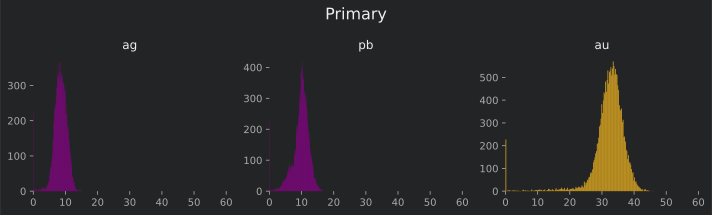

In [40]:
pm = plot_hist(to_plot[1], gold_recovery_full, 'Primary')

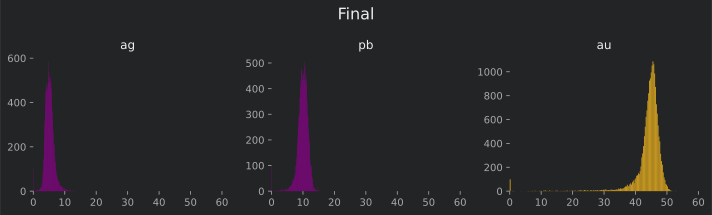

In [41]:
fm = plot_hist(to_plot[2], gold_recovery_full, 'Final')

In [42]:
descr_methals(pd.DataFrame(pd.concat(
            [rm['pb'].rename('rougher_pb'),
                pm['pb'].rename('primary_pb'),
                fm['pb'].rename('final_pb'),],
            axis=1,)),
    phase_title='Свинец, концентрация'
)

Свинец, концентрация


,rougher_pb,primary_pb,final_pb
count,19439.000000,19323.000000,19438.000000
mean,7.606272,9.829530,9.978895
std,1.796757,2.556843,1.669240
min,0.000000,0.000000,0.000000
0.5%,0.000000,0.000000,0.001850
2.5%,3.489990,3.678817,6.518952
50%,7.742580,10.152433,10.102433
97.5%,10.916063,14.029533,12.673041
99.5%,11.989667,15.258920,13.524733
max,13.617072,17.081278,17.031899


In [43]:
descr_methals(pd.DataFrame(pd.concat(
            [rm['ag'].rename('rougher_ag'),
                pm['ag'].rename('primary_ag'),
                fm['ag'].rename('final_ag'),],
            axis=1,)),
    phase_title='Серебро, концентрация'
)

Серебро, концентрация


,rougher_ag,primary_ag,final_ag
count,19439.000000,19439.000000,19438.000000
mean,11.994759,8.442408,5.168470
std,2.733862,2.054465,1.372348
min,0.000000,0.000000,0.000000
0.5%,0.000000,0.000000,0.001850
2.5%,5.573315,4.140096,3.046687
50%,12.098115,8.507298,5.066094
97.5%,16.150374,11.946014,8.259669
99.5%,18.188382,12.860209,10.170913
max,24.480271,16.081632,16.001945


In [44]:
descr_methals(pd.DataFrame(pd.concat(
            [rm['au'].rename('rougher_au'),
                pm['au'].rename('primary_au'),
                fm['au'].rename('final_au'),],
            axis=1,)),
    phase_title='Золото, концентрация'
)

Золото, концентрация


,rougher_au,primary_au,final_au
count,19439.000000,19439.000000,19438.000000
mean,19.772000,32.119400,44.077287
std,3.753600,5.627611,5.128779
min,0.000000,0.000000,0.000000
0.5%,0.000000,0.000000,0.001850
2.5%,9.901529,17.090707,32.592658
50%,20.280214,32.841295,45.011348
97.5%,24.374156,39.460115,48.816373
99.5%,25.720501,41.458570,49.969677
max,28.824507,45.933934,52.756638


#### Выводы о концентрации Pb, Ag, Au 

Медиана концентрации Свинца `Pb` увеличивается с 7,7% после Флотации и далее остаётся около 10,1%.  
Медиана концентрации Серебра `Ag` снижается с 12% после Флотации до 5% после Финальной отчистки.  
Медиана концентрации Золота `Au` увеличивается скаждым этапом с 20,3% до 45%.  
    Это радует, мы ведь Золото добываем)  
  
Интересно, что стандартное отклонение увеличивается с 3,8 до 5,6 (5,1), несмотря на сужение гистограмы концентрации золота. В левой части гистограмы всё ещё много выбросов за 95% интервал.  
  
Хотя природа появления нулевых концентраций не известна (ошибки в данных, ошибки в замерах или ..), но количество нулевых концентраций всех металлов снижается по мере отчистки.

### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной

In [45]:
display(
    gold_recovery_train['rougher.input.feed_size'].describe(),
    gold_recovery_test['rougher.input.feed_size'].describe(),
)

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

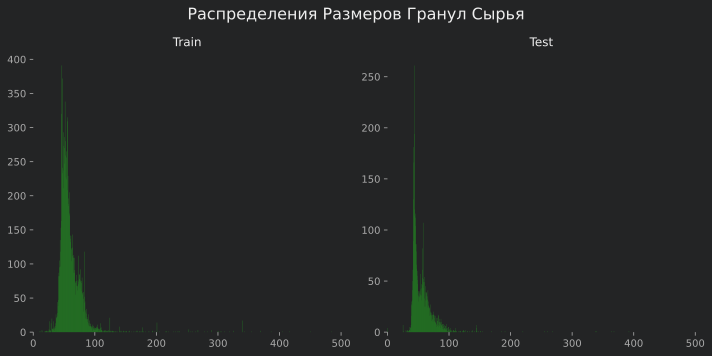

In [46]:
plot_feed_size_hist(
    gold_recovery_train['rougher.input.feed_size'],
    gold_recovery_test['rougher.input.feed_size'],
    'Распределения Размеров Гранул Сырья'
)

Посмотрим на 99% доверительные интервалы для выборок `test` и `train` параметра `rougher.input.feed_size`

In [47]:
print(
    'Train',
    round(gold_recovery_train[
            'rougher.input.feed_size'
        ].quantile(0.005), 5),
    round(gold_recovery_train[
            'rougher.input.feed_size'
        ].quantile(0.5), 5),
    round(gold_recovery_train[
            'rougher.input.feed_size'
        ].quantile(0.995), 5),
    sep='\n\t',
)
print(
    'Test',
    round(
        gold_recovery_test[
            'rougher.input.feed_size'
        ].quantile(0.005), 5),
    round(gold_recovery_test[
            'rougher.input.feed_size'
        ].quantile(0.5), 5),
    round(gold_recovery_test[
            'rougher.input.feed_size'
        ].quantile(0.995), 5),
    sep='\n\t',
)

Train
	30.50522
	55.26978
	200.99543
Test
	35.77432
	50.84684
	144.45971


Выглядит как не самая `случайная` выборка.

Удалим выбросы `rougher.input.feed_size` из `test` и `train`, те что больше 0,999 квантиля `train` выборки.

In [48]:
print(
    len(gold_recovery_train.index),
    len(gold_recovery_test.index),
)

up_to_size = gold_recovery_train[ 'rougher.input.feed_size'].quantile(0.999)

gold_recovery_train.drop(
    index=gold_recovery_train.loc[ 
        gold_recovery_train['rougher.input.feed_size'] > up_to_size
    ].index,
    inplace=True,
)
gold_recovery_test.drop(
    index=gold_recovery_test.loc[
        gold_recovery_test['rougher.input.feed_size'] > up_to_size
    ].index,
    inplace=True,
)

print(
    len(gold_recovery_train.index),
    len(gold_recovery_test.index),
)

14149 5290
14134 5286


Не велика потеря в 0.1% 🔬

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

`Rougher`  ➡️  `Primary`  ➡️  `Final`

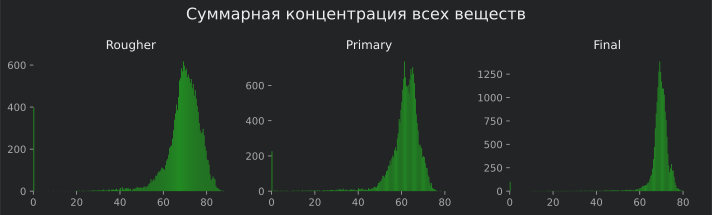

In [49]:
rc, pc, fc = plot_hist_conc(
        gold_recovery_full,
        title='Cуммарная концентрация всех веществ'
    )

In [50]:
display(
    pd.DataFrame(
        data=(np.concatenate(
                (
                    np.reshape(rc.describe(
                            percentiles=[.005, .025, .25,  .5, .75, .975, .995]
                        ).values,
                        [-1, 1]
                    ),
                    np.reshape(pc.describe(
                            percentiles=[.005, .025, .25,  .5, .75, .975, .995]
                        ).values,
                        [-1, 1]
                    ),
                    np.reshape(fc.describe(
                            percentiles=[.005, .025, .25,  .5, .75, .975, .995]
                        ).values,
                        [-1, 1]
                    ),
                ),
                axis=1
            )
        ),
        index=rc.describe(percentiles=[.005, .025, .25,  .5, .75, .975, .995]).index,
        columns=['Rougher', 'Primary', 'Final']
    )
)

,Rougher,Primary,Final
count,19416.000000,19069.000000,19227.000000
mean,68.188914,60.949928,68.727562
std,12.478522,9.953770,7.423741
min,0.000000,0.000000,0.000000
0.5%,0.000000,0.000000,0.000000
2.5%,33.969876,32.905568,54.157814
25%,66.026048,59.165854,67.985659
50%,70.186130,62.615189,69.632597
75%,74.362878,65.725507,71.390461
97.5%,81.211354,71.624811,75.569975


Стандартное откланение уменьшается с ходом отчистки.  
Это видно и по графикам: форма распределения сужается от этапа к этапу.  
Но вот что странно так это нулевые суммы.. Хотя колличество нулей и уменьшается примерно вдвое на каждом из шагов отчистки.

Посмотрим откуда берётся нуль..

In [51]:
display(
    gold_recovery_full.loc[
        (gold_recovery_full['rougher.output.concentrate_ag'] == gold_recovery_full['rougher.output.concentrate_pb'])
        & (gold_recovery_full['rougher.output.concentrate_pb'] == gold_recovery_full['rougher.output.concentrate_sol'])
        & (gold_recovery_full['rougher.output.concentrate_sol'] == gold_recovery_full['rougher.output.concentrate_au'])
        & (gold_recovery_full['rougher.output.concentrate_ag'] == 0),
    ].sample(5),
    gold_recovery_full.loc[
        (gold_recovery_full['primary_cleaner.output.concentrate_ag'] == gold_recovery_full['primary_cleaner.output.concentrate_pb'])
        & (gold_recovery_full['primary_cleaner.output.concentrate_pb'] == gold_recovery_full['primary_cleaner.output.concentrate_sol'])
        & (gold_recovery_full['primary_cleaner.output.concentrate_sol'] == gold_recovery_full['primary_cleaner.output.concentrate_au'])
        & (gold_recovery_full['primary_cleaner.output.concentrate_ag'] == 0),
    ].sample(5),
    gold_recovery_full.loc[
        (gold_recovery_full['final.output.concentrate_ag'] == gold_recovery_full['final.output.concentrate_pb'])
        & (gold_recovery_full['final.output.concentrate_pb'] == gold_recovery_full['final.output.concentrate_sol'])
        & (gold_recovery_full['final.output.concentrate_sol'] == gold_recovery_full['final.output.concentrate_au'])
        & (gold_recovery_full['final.output.concentrate_ag'] == 0),
    ].sample(5),
)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-04 17:59:59,3.508868,9.828640,8.905355,48.624757,57.120911,8.538334,3.216952,10.709875,4.075125,141.260562,8.041141,7.94,0.593102,6.104202,11.386087,9.637802,38.726044,14.770995,3.067054,8.221485,5.469292,1302.984840,-499.988453,1297.834274,-500.210380,1295.561077,-500.383800,1300.727218,-500.961691,44131.134826,2630.029767,2631.723103,2.197111,8.165473,3.891149,484.919239,49.327578,36.451326,8.549287,11.005072,5.603654,10.988847,5.600744,0.0,0.0,0.0,0.0,0.0,7.097876,1.043818,18.038498,2.933052,1002.169409,-350.264960,1250.116069,-499.777594,1252.350091,-498.934775,1204.485161,-497.283209,1000.370368,-499.671292,950.001333,-499.488197,12.891285,5.392984,9.401645,6.025343,21.892937,-500.215726,11.910100,-499.828208,17.915118,-500.204936,10.019201,-499.996423,12.046691,-500.231568,7.966400,-498.782241,7.977692,-502.014930,4.998612,-500.527864,9.948471,-498.000234
2017-10-22 09:59:59,5.178215,10.675492,9.205052,45.081730,53.324497,11.388432,5.482500,12.878155,4.34318

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-06 22:59:59,3.554558,12.202148,13.827148,44.528214,67.275195,7.958822,4.226074,9.827148,3.199278,0.003112,0.088080,7.79,NaN,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1609.314063,-499.501752,1600.236349,-500.641473,1602.695101,-498.739358,1614.328845,-506.946028,-38.306340,21.398871,5.370007,1.690585,7.061728,5.038574,0.160083,45.914930,36.808594,8.518138,0.073245,0.009512,0.018261,NaN,9.975555,10.452148,31.654297,20.341888,91.792293,4.576932,0.582947,15.202148,1.135672,1001.917835,-501.053133,1407.953196,-606.220301,1414.938226,-609.369147,1409.813099,-591.686576,1107.842256,-646.831910,1007.944675,-646.593455,0.000000,0.000000,0.000000,0.000000,29.978060,-425.084175,27.984731,-530.607277,34.990781,-500.510452,32.028200,-500.069111,16.962551,-494.914843,15.041905,-497.331346,18.810199,-496.572071,7.928144,-495.842586,20.022128,-591.650434
2017-07-08 09:59:59,7.195085,8.459563,9.752025,40.992581,60.560667,7.144608,2.674782,8.346977,2.862802,85.046613,4.90

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-13 13:59:59,0.0,0.0,0.0,0.0,0.0,6.926711,3.089169,8.525328,2.632344,91.702137,5.044698,6.790000,0.990615,5.231119,8.107073,1.150856,38.211235,14.097574,2.826173,6.629499,4.180351,1397.421982,-495.575892,1396.621563,-503.780005,1401.647332,-500.047997,1403.032956,-500.185750,45004.928399,5655.323144,5653.378337,2.027722,5.644226,3.570724,346.420330,72.981282,33.082689,7.240437,13.062691,4.514480,13.058280,4.515565,9.037068,9.381008,31.742519,21.286666,87.484721,3.464928,0.347457,15.343825,1.290038,994.025229,-299.735309,1093.953266,-499.349823,1046.677736,-500.193267,992.342867,-497.120444,902.195794,-499.007041,901.096407,-499.117306,17.300039,6.832676,NaN,3.835786,24.976822,-498.435315,21.992883,-499.808422,22.024960,-482.170569,19.999654,-491.715520,17.982029,-494.475716,16.036243,-399.213499,12.945032,-494.955276,10.001027,-499.591320,14.000650,-498.537977
2016-08-30 19:59:59,0.0,0.0,0.0,0.0,0.0,7.950315,3.216058,3.705181,4.844750,23.532957,4.029503,5.710001,0.

Если `concentrate` это расчётные значения, то похоже что калькулятор барахлил.. 🧮

<hr>

<a id='go'></a>
## 3. Постройте модель

Отделим флотацию от остальных этапов.

In [52]:
rougher_col = pd.Series(gold_recovery_train.columns).apply(
        lambda col: col if 'rougher.' in col else None
    ).dropna()

In [53]:
target_rougher_train = gold_recovery_train['rougher.output.recovery']
features_rougher_train = gold_recovery_train[
        rougher_col
    ].drop(
        columns='rougher.output.recovery',
    )

In [54]:
target_rougher_test = gold_recovery_test['rougher.output.recovery']
features_rougher_test = gold_recovery_test[
        rougher_col
    ].drop(
        columns='rougher.output.recovery',
    )

In [55]:
features_rougher_train.describe()

,rougher.input.feed_ag,rougher.input.feed_au,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
count,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000
mean,8.580284,7.867841,3.505740,474.057994,59.906595,36.297562,11.746452,5.855552,11.366478,5.805592,1124.830145,-369.542741,1320.740659,-464.333467,1299.375014,-465.130562,1210.314278,-465.543595,1084.249954,-464.997154,1035.422065,-464.762076
std,1.896420,1.919356,1.090047,104.063916,20.565665,4.967400,3.303858,1.102988,3.797201,1.237923,169.344847,93.979038,183.259205,57.387253,213.523000,55.886377,210.536406,55.729566,186.317912,56.577452,175.071854,56.629374
min,0.010000,0.010000,0.010000,0.012786,9.659576,0.010000,0.001083,0.001428,0.000098,0.000290,-0.041078,-650.202881,-0.653384,-650.260008,-0.035112,-640.995627,-0.554299,-640.519003,-1.970275,-649.443911,-2.430587,-649.880981
25%,7.134493,6.597833,2.766747,420.779423,48.965086,34.091809,9.842402,5.126699,9.501543,5.097695,999.800611,-499.788732,1199.359856,-500.183788,1103.081961,-500.212695,1059.219443,-500.361155,951.230725,-500.250855,900.959408,-500.478213
50%,8.156495,7.649267,3.414292,499.463686,55.263263,37.009585,11.657094,5.954168,11.376963,5.992818,1001.693000,-300.175363,1301.386891,-499.765455,1300.217730,-499.683863,1200.744185,-499.467480,1050.144930,-499.612380,1000.053679,-499.367364
75%,9.919442,9.070610,4.219974,547.347400,65.966353,39.414214,13.571301,6.602632,13.497431,6.649646,1299.507583,-299.963453,1449.585753,-400.427734,1450.362362,-400.668988,1344.645580,-401.065629,1199.901282,-400.609721,1100.164422,-401.029787
max,14.596026,13.126043,7.142594,717.508837,339.249301,48.363177,36.118275,9.703448,37.980648,9.698407,1521.980372,-281.039299,1809.194008,-296.383080,2499.129174,-292.155509,1817.199290,-208.330673,1922.636637,-272.199598,1706.307502,-191.718480


Проверим на мультиколлинеарность.

Посмотрим на коэффициент корреляции Пирсона. Между параметрами флотации.

In [56]:
rougher_corr = features_rougher_train.corr().abs().unstack().sort_values().drop_duplicates()

display(
    rougher_corr[
        (rougher_corr > 0.5)
        & (rougher_corr < 1.0)
    ]
)

rougher.input.feed_pb               rougher.input.feed_ag                 0.501490
rougher.input.feed_sol              rougher.input.feed_rate               0.540256
rougher.state.floatbank10_a_air     rougher.state.floatbank10_a_level     0.573610
rougher.input.floatbank10_xanthate  rougher.input.feed_rate               0.599281
rougher.input.floatbank11_xanthate  rougher.input.feed_rate               0.650338
rougher.input.feed_au               rougher.input.feed_pb                 0.702438
rougher.state.floatbank10_c_air     rougher.state.floatbank10_f_air       0.757796
                                    rougher.state.floatbank10_e_air       0.778544
rougher.input.floatbank10_sulfate   rougher.input.floatbank11_sulfate     0.798483
rougher.state.floatbank10_f_air     rougher.state.floatbank10_b_air       0.824192
rougher.state.floatbank10_e_air     rougher.state.floatbank10_b_air       0.828338
rougher.input.feed_ag               rougher.input.feed_au                 0.845520
roug

In [57]:
rougher_floatbank10_levels = [
            'rougher.state.floatbank10_a_level',
            'rougher.state.floatbank10_b_level',
            'rougher.state.floatbank10_c_level',
            'rougher.state.floatbank10_d_level',
            'rougher.state.floatbank10_e_level',
            'rougher.state.floatbank10_f_level',
        ]

rougher_floatbank10_airs = [
            'rougher.state.floatbank10_a_air',
            'rougher.state.floatbank10_b_air',
            'rougher.state.floatbank10_c_air',
            'rougher.state.floatbank10_d_air',
            'rougher.state.floatbank10_e_air',
            'rougher.state.floatbank10_f_air',
        ]

rougher_input_floatbanks_sulfate_mean = [
            'rougher.input.floatbank10_sulfate',
            'rougher.input.floatbank11_sulfate',
        ]

rougher_input_floatbanks_xanthate_mean = [
            'rougher.input.floatbank10_xanthate',
            'rougher.input.floatbank11_xanthate',
        ]

In [58]:
primary_cleaner_mean_air = [
        'primary_cleaner.state.floatbank8_a_air',
        'primary_cleaner.state.floatbank8_b_air',
        'primary_cleaner.state.floatbank8_c_air',
        'primary_cleaner.state.floatbank8_d_air',
    ]

primary_cleaner_mean_level = [
        'primary_cleaner.state.floatbank8_a_level',
        'primary_cleaner.state.floatbank8_b_level',
        'primary_cleaner.state.floatbank8_c_level',
        'primary_cleaner.state.floatbank8_d_level',
    ]

secondary_cleaner_mean_air = [
        'secondary_cleaner.state.floatbank2_a_air',
        'secondary_cleaner.state.floatbank2_b_air',
        'secondary_cleaner.state.floatbank3_a_air',
        'secondary_cleaner.state.floatbank3_b_air',
        'secondary_cleaner.state.floatbank4_a_air',
        'secondary_cleaner.state.floatbank4_b_air',
        'secondary_cleaner.state.floatbank5_a_air',
        'secondary_cleaner.state.floatbank5_b_air',
        'secondary_cleaner.state.floatbank6_a_air',
    ]

secondary_cleaner_mean_level = [
        'secondary_cleaner.state.floatbank2_a_level',
        'secondary_cleaner.state.floatbank2_b_level',
        'secondary_cleaner.state.floatbank3_a_level',
        'secondary_cleaner.state.floatbank3_b_level',
        'secondary_cleaner.state.floatbank4_a_level',
        'secondary_cleaner.state.floatbank4_b_level',
        'secondary_cleaner.state.floatbank5_a_level',
        'secondary_cleaner.state.floatbank5_b_level',
        'secondary_cleaner.state.floatbank6_a_level',
    ]

In [59]:
def create_mean_col(features_df):
    features_df['rougher.state.floatbank10_mean_level'] = features_df.loc[: ,
            rougher_floatbank10_levels
        ].apply(np.mean, axis=1)
    features_df.drop(
            columns=rougher_floatbank10_levels,
            inplace=True,
        )

    features_df['rougher.state.floatbank10_mean_air'] = features_df.loc[: ,
            rougher_floatbank10_airs
        ].apply(np.mean, axis=1)
    features_df.drop(
            columns=rougher_floatbank10_airs,
            inplace=True,
        )

    features_df['rougher.input.floatbanks_xanthate_mean'] = features_df.loc[: ,
            rougher_input_floatbanks_xanthate_mean
        ].apply(np.mean, axis=1)
    features_df.drop(
            columns=rougher_input_floatbanks_xanthate_mean,
            inplace=True,
        )

    features_df['rougher.input.floatbanks_sulfate_mean'] = features_df.loc[: ,
            rougher_input_floatbanks_sulfate_mean
        ].apply(np.mean, axis=1)
    features_df.drop(
            columns=rougher_input_floatbanks_sulfate_mean,
            inplace=True,
        )
    
    return features_df

In [60]:
def create_final_mean_col(features_final_df):
    features_final_df['primary_cleaner.state.mean_air'] = features_final_df.loc[: ,
            primary_cleaner_mean_air
        ].apply(np.mean, axis=1)
    features_final_df.drop(
            columns=primary_cleaner_mean_air,
            inplace=True,
        )
    
    features_final_df['primary_cleaner.state.mean_level'] = features_final_df.loc[: ,
            primary_cleaner_mean_level
        ].apply(np.mean, axis=1)
    features_final_df.drop(
            columns=primary_cleaner_mean_level,
            inplace=True,
        )
    
    features_final_df['secondary_cleaner.state.mean_air'] = features_final_df.loc[: ,
            secondary_cleaner_mean_air
        ].apply(np.mean, axis=1)
    features_final_df.drop(
            columns=secondary_cleaner_mean_air,
            inplace=True,
        )
    
    features_final_df['secondary_cleaner.state.mean_level'] = features_final_df.loc[: ,
            secondary_cleaner_mean_level
        ].apply(np.mean, axis=1)
    features_final_df.drop(
            columns=secondary_cleaner_mean_level,
            inplace=True,
        )
    
    return features_final_df

In [61]:
features_rougher_train = create_mean_col(features_rougher_train)

In [62]:
display(
    features_rougher_train.head()
)

,rougher.input.feed_ag,rougher.input.feed_au,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.state.floatbank10_mean_level,rougher.state.floatbank10_mean_air,rougher.input.floatbanks_xanthate_mean,rougher.input.floatbanks_sulfate_mean
date,,,,,,,,,,
2016-01-15 00:00:00,6.100378,6.486150,2.284912,523.546326,55.486599,36.808594,-439.947205,1437.476257,6.006904,11.911680
2016-01-15 01:00:00,6.161113,6.478583,2.266033,525.290581,57.278666,35.753385,-441.798629,1433.499125,6.009180,11.983678
2016-01-15 02:00:00,6.116455,6.362222,2.159622,530.026610,57.510649,35.971630,-441.742662,1433.012774,6.201005,11.920454
2016-01-15 03:00:00,6.043309,6.118189,2.037807,542.590390,57.792734,36.862241,-441.780288,1433.131689,6.199877,11.661272
2016-01-15 04:00:00,6.060915,5.663707,1.786875,540.531893,56.047189,34.347666,-441.430137,1433.787571,6.196861,10.959138


У серебра и свинца средняя кореляция с золотом, ~~а нужен ли нам свинец и серебро?~~  
Похоже что нужны, без них r2 

> **метод предварительного центрирования**. Суть метода сводится к тому, что перед нахождением параметров математической модели проводится центрирование исходных данных: из каждого значения в ряде данных вычитается среднее по ряду: $$\large Y'_t = Y_t - \bar{Y}$$  
Эта процедура позволяет так развести гиперплоскости условий МНК, чтобы углы между ними были перпендикулярны. В результате этого оценки модели становятся устойчивыми.  

© [machinelearning.ru/wiki](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D1%83%D0%BB%D1%8C%D1%82%D0%B8%D0%BA%D0%BE%D0%BB%D0%BB%D0%B8%D0%BD%D0%B5%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C#.D0.9C.D0.B5.D1.82.D0.BE.D0.B4.D1.8B_.D1.83.D1.81.D1.82.D1.80.D0.B0.D0.BD.D0.B5.D0.BD.D0.B8.D1.8F_.D0.BC.D1.83.D0.BB.D1.8C.D1.82.D0.B8.D0.BA.D0.BE.D0.BB.D0.BB.D0.B8.D0.BD.D0.B5.D0.B0.D1.80.D0.BD.D0.BE.D1.81.D1.82.D0.B8)

**метод предварительного центрирования** не помог(

### 3.1. Напишите функцию для вычисления итоговой sMAPE.

$$\large
sMAPE = \frac{1}{N} * \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} * 100\%
$$

где:  
- $\large y_i$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество; 
- $\large \hat{y_i}$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке;
- $\large N$ - количество объектов в выборке;

$$\large
sMAPE = 25\% * sMAPE_{rougher} + 75\% * sMAPE_{final}
$$

In [63]:
def final_smpe (target_rough_test, target_rough_pred, target_final_test, target_final_pred):
    rough_smape = mean_absolute_percentage_error(
            target_rough_test,
            target_rough_pred
        )
    final_smape = mean_absolute_percentage_error(
            target_final_test,
            target_final_pred
        )
    
    smape = (.25 * rough_smape) + (.75 *  final_smape)
    
    return smape

### 3.2. Обучите разные модели и оцените их качество кросс-валидацией.

#### Модели для `rougher.output.recovery`

Применим `MinMaxScaler`

In [64]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(features_rougher_train)

features_rougher_train_scaled = mm_scaler.transform(features_rougher_train)

##### LinearRegression

In [65]:
lin_reg = LinearRegression()

In [66]:
# create a KFold object with 5 splits 
folds = KFold(
    n_splits=5,
    shuffle=True,
    random_state=random_seed
)
r2_scores = cross_val_score(
    lin_reg,
    features_rougher_train_scaled,
    target_rougher_train,
    scoring='r2',
    cv=folds
)

In [67]:
print(r2_scores)
print(np.median(r2_scores))

[0.09732282 0.15677993 0.13065087 0.15062077 0.1164642 ]
0.13065086741930187


🤦‍♂️

Подсмотрел в статье на kaggle [Cross-Validation with Linear Regression](https://www.kaggle.com/code/jnikhilsai/cross-validation-with-linear-regression)

Очень долго отрабатывает..  
Не дождался ⏱️

> We can use Ridge or Lasso Regression because in these types of regression techniques we add an extra lambda value which penalizes some of the coefficients for particular columns which in turn reduces the effect of multicollinearity.  
  
©  Princeton Baretto [Removing Multicollinearity for Linear and Logistic Regression.](https://medium.com/analytics-vidhya/removing-multi-collinearity-for-linear-and-logistic-regression-f1fa744f3666#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjcxM2ZkNjhjOTY2ZTI5MzgwOTgxZWRjMDE2NGEyZjZjMDZjNTcwMmEiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2Njc5MzE0NDcsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExNjcxNjE4ODM4MzM0NTI2MTcwMiIsImVtYWlsIjoiYWxla3NleS56YWJlbGluQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJuYW1lIjoiQWxla3NleSBaYWJlbGluIiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FMbTV3dTJTbzlOdmF6SnQ4T1ZiXzYwSXNPZnNYQXFHRGpkLXhZbkR6LTM1UGc9czk2LWMiLCJnaXZlbl9uYW1lIjoiQWxla3NleSIsImZhbWlseV9uYW1lIjoiWmFiZWxpbiIsImlhdCI6MTY2NzkzMTc0NywiZXhwIjoxNjY3OTM1MzQ3LCJqdGkiOiJlOWFmZDdhMjhjZDhiYmQ4NjBlNWRhMjZjZGUyOWIyNWRjNjgwZGI1In0.F7c5vksF4EFvGWsz8dj03iAfNHxoRggJmT58HIG90FGuJprXGxC7GzZA6HzTM7xDGBSSvkLJiTFaPXGV1dFFunm2hN0zr2cOKuhlX1DOLsnJttEgx8DkiYdokL1cCNQiO8WXJOz5wvO1676KXfgKxp0qjvY0_ME7MItLdBwFyRXQjcfmheXz4ufS5pR66WG9DeReRRdwU4sO1cpIhBrYtU11lEWZ8uc9U5NgfnVILF1RwAOH5p_T0xlKRByJHMaalStOte71pfGhyiVdfnJ8HIKdM6WVxs3gmOgAkz5t0u2bPUcqkAneua_aFPqfayWK038uka1SsrbppQBsCY_iZw)

##### RidgeCV

In [68]:
ridgle_rougher = RidgeCV(
    cv=folds,
    scoring='r2'
    # random_state=random_seed,
)

In [69]:
ridgle_rougher.fit(features_rougher_train_scaled, target_rougher_train)

RidgeCV(cv=KFold(n_splits=5, random_state=108108108, shuffle=True),
        scoring='r2')

In [70]:
ridgle_rougher.score(features_rougher_train_scaled, target_rougher_train)

0.1313255521584734

🤦‍♂️

##### LassoCV

In [71]:
lasso_rougher = LassoCV(
    cv=folds,
    # scoring='r2'
    random_state=random_seed,
)

In [72]:
lasso_rougher.fit(features_rougher_train_scaled, target_rougher_train)

LassoCV(cv=KFold(n_splits=5, random_state=108108108, shuffle=True),
        random_state=108108108)

In [73]:
lasso_rougher.score(features_rougher_train_scaled, target_rougher_train)

0.1310220416082547

🤦‍♂️

#### Модели для `final.output.recovery`

In [74]:
train_corr = gold_recovery_train.corr().abs().unstack().sort_values().drop_duplicates()

display(
    train_corr[(train_corr > 0.6) & (train_corr < 1.0)]
)

primary_cleaner.input.sulfate               rougher.input.feed_au                         0.605966
secondary_cleaner.state.floatbank4_a_air    rougher.state.floatbank10_a_level             0.607962
secondary_cleaner.state.floatbank4_b_air    secondary_cleaner.state.floatbank3_b_air      0.623371
secondary_cleaner.state.floatbank5_b_air    secondary_cleaner.state.floatbank3_b_air      0.632459
secondary_cleaner.state.floatbank3_a_level  secondary_cleaner.state.floatbank5_b_level    0.644124
rougher.input.floatbank11_xanthate          rougher.input.feed_rate                       0.650338
secondary_cleaner.state.floatbank3_a_level  secondary_cleaner.state.floatbank3_b_level    0.653779
primary_cleaner.state.floatbank8_c_level    primary_cleaner.state.floatbank8_d_level      0.675467
secondary_cleaner.state.floatbank4_a_air    secondary_cleaner.state.floatbank3_a_air      0.681657
secondary_cleaner.state.floatbank3_b_air    secondary_cleaner.state.floatbank3_a_air      0.690921
primary_cl

In [75]:
target_final_train = gold_recovery_train['final.output.recovery']
features_final_train = gold_recovery_train.drop(columns='final.output.recovery')

In [76]:
features_final_train = create_mean_col(features_final_train)

In [77]:
features_final_train = create_final_mean_col(features_final_train)

У серебра и свинца средняя кореляция с золотом, ~~а нужен ли нам свинец и серебро?~~  
Похоже что нужны, без них r2 

Применим `MinMaxScaler`

In [78]:
mm_final_scaler = MinMaxScaler()
mm_final_scaler.fit(features_final_train)

features_final_train_scaled = mm_final_scaler.transform(features_final_train)

##### LinearRegression()

In [79]:
lin_reg_final = LinearRegression()

In [80]:
# create a KFold object with 5 splits 
folds = KFold(
    n_splits=5,
    shuffle=True,
    random_state=random_seed
)
r2_scores_final = cross_val_score(
    lin_reg_final,
    features_final_train_scaled,
    target_final_train,
    scoring='r2',
    cv=folds
)
print(r2_scores_final)

[0.29695142 0.29061394 0.29620274 0.27926541 0.28075215]


In [81]:
display(
    np.median(r2_scores_final)
)

0.29061393705686145

##### RidgeCV

In [82]:
ridgle_final = RidgeCV(
    cv=folds,
    scoring='r2'
    # random_state=random_seed,
)

In [83]:
ridgle_final.fit(features_final_train_scaled, target_final_train)

RidgeCV(cv=KFold(n_splits=5, random_state=108108108, shuffle=True),
        scoring='r2')

In [84]:
ridgle_final.score(features_final_train_scaled, target_final_train)

0.29141871152251075

##### LassoCV

In [85]:
lasso_final = LassoCV(
    cv=folds,
    # scoring='r2'
    random_state=random_seed,
)

In [86]:
lasso_final.fit(features_final_train_scaled, target_final_train)

LassoCV(cv=KFold(n_splits=5, random_state=108108108, shuffle=True),
        random_state=108108108)

In [87]:
lasso_final.score(features_final_train_scaled, target_final_train)

0.2914205410035954

<hr>

### 3.3. Выберите лучшую модель и проверьте её на тестовой выборке.

Для `rougher` возьмём `Ridgle`

In [88]:
features_rougher_test = create_mean_col(features_rougher_test)

У серебра и свинца средняя кореляция с золотом, ~~а нужен ли нам свинец и серебро?~~  
Похоже что нужны, без них r2 

Применим `MinMaxScaler`

In [89]:
features_rougher_test_scaled = mm_scaler.transform(features_rougher_test)

In [90]:
target_rougher_pred = ridgle_rougher.predict(
    features_rougher_test_scaled
)

print(
    r2_score(target_rougher_test, target_rougher_pred)
)

0.07962464489272802


🧱

Разделим `final` на `features` и `target`

In [91]:
target_final_test = gold_recovery_test['final.output.recovery']
features_final_test = gold_recovery_test.drop(
        columns='final.output.recovery'
    )

In [92]:
features_final_test = create_mean_col(features_final_test)

In [93]:
features_final_test = create_final_mean_col(features_final_test)

Применим `MinMaxScaler`

In [94]:
features_final_test_scaled = mm_final_scaler.transform(features_final_test)

Для `final` возьмём `Ridgle`

In [95]:
target_final_pred = ridgle_final.predict(features_final_test_scaled)

print(
    r2_score(target_final_test, target_final_pred)
)

0.04094919716843348


In [98]:
print(
    final_smpe(target_rougher_test, target_rougher_pred, target_final_test, target_final_pred)
)

3279985170345159.0


### 3.4 Опишите выводы.

Конечно, что+то тут не так...
Тут понять бы как разобраться с мультиколлинеарностью, и выбором параметров.
Потомучто r2 очень низкий, а уж sMAPE - это 🛸..